In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

In [305]:
df = pd.read_csv("/Users/salmonm/Downloads/premier-player-23-24.csv")

In [306]:
df = df.dropna(subset=['Age', 'Gls', 'Ast', 'xG', 'npxG', 'xAG', 'PrgC', 'PrgR', 'PrgP'])

In [307]:
print(df.head())
print(df.info())

           Player   Nation    Pos   Age  MP  Starts     Min   90s   Gls  Ast  \
0           Rodri   es ESP     MF  27.0  34      34  2931.0  32.6   8.0  9.0   
1      Phil Foden  eng ENG  FW,MF  23.0  35      33  2857.0  31.7  19.0  8.0   
2         Ederson   br BRA     GK  29.0  33      33  2785.0  30.9   0.0  0.0   
3  Julián Álvarez   ar ARG  MF,FW  23.0  36      31  2647.0  29.4  11.0  8.0   
4     Kyle Walker  eng ENG     DF  33.0  32      30  2767.0  30.7   0.0  4.0   

   ...  Ast_90  G+A_90  G-PK_90  G+A-PK_90  xG_90  xAG_90  xG+xAG_90  npxG_90  \
0  ...    0.28    0.52     0.25       0.52   0.12    0.12       0.24     0.12   
1  ...    0.25    0.85     0.60       0.85   0.33    0.26       0.59     0.33   
2  ...    0.00    0.00     0.00       0.00   0.00    0.00       0.00     0.00   
3  ...    0.27    0.65     0.31       0.58   0.44    0.22       0.66     0.39   
4  ...    0.13    0.13     0.00       0.13   0.01    0.09       0.10     0.01   

   npxG+xAG_90             Team 

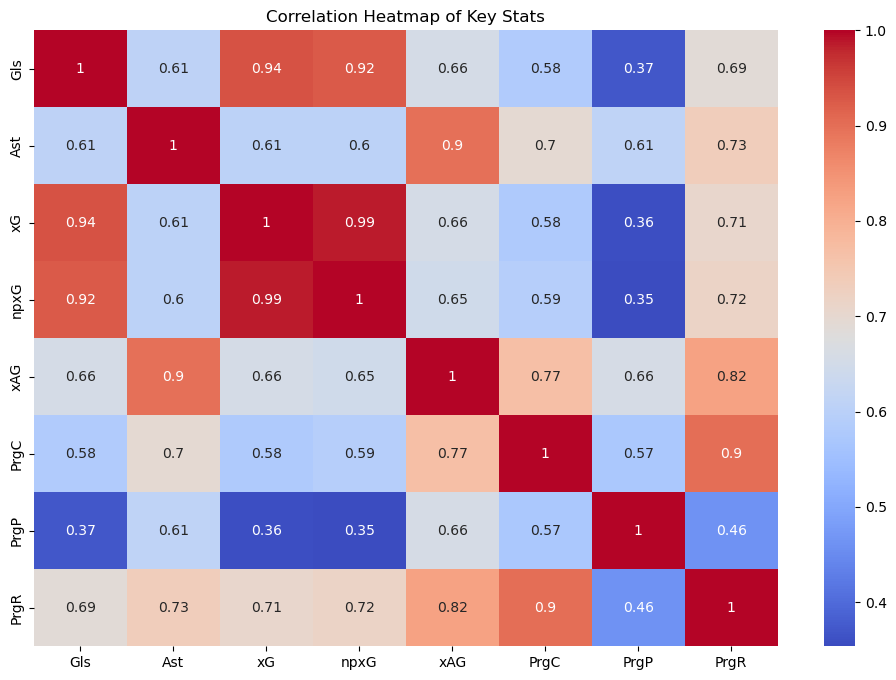

In [308]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[['Gls', 'Ast', 'xG', 'npxG', 'xAG', 'PrgC', 'PrgP', 'PrgR']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Key Stats')
plt.show()

In [309]:
features = df[['PrgC', 'PrgR', 'PrgP']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [310]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

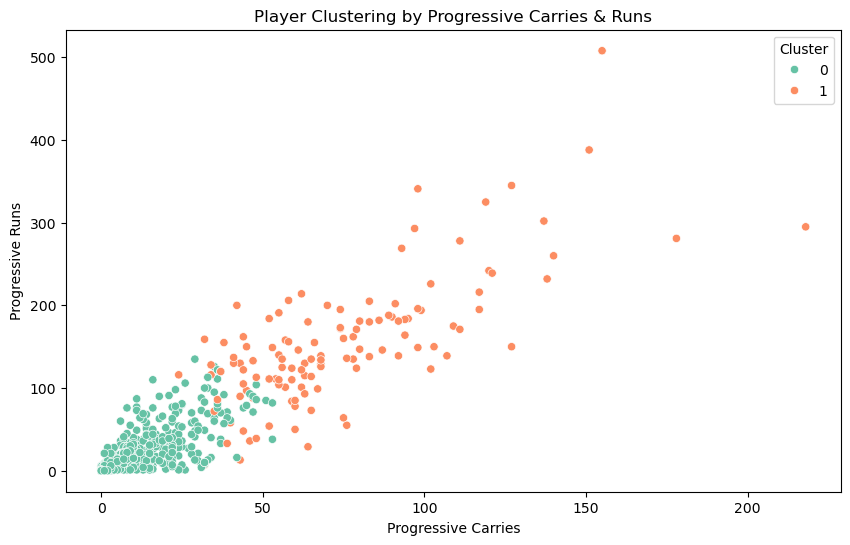

In [311]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PrgC', y='PrgR', hue='Cluster', palette='Set2')
plt.title('Player Clustering by Progressive Carries & Runs')
plt.xlabel('Progressive Carries')
plt.ylabel('Progressive Runs')
plt.show()

In [312]:
# กรองแถวที่มีการลงเล่นจริง (หลีกเลี่ยง 0 นาที)
df = df[df['90s'] > 0]

# สร้างค่าประตูต่อ 90 นาที
df['GoalsPer90'] = df['Gls'] / df['90s']

In [313]:
X = df[['xG', 'xAG', 'npxG', 'PrgC', 'PrgP', 'PrgR']]
y = df['GoalsPer90']

# เผื่อมี NaN จากคอลัมน์อื่น ให้ dropna อีกรอบ
X = X[~y.isna()]
y = y.dropna()

In [314]:
df['GoalsPer90'] = df['Gls'] / df['90s']
X = df[['xG', 'xAG', 'npxG', 'PrgC', 'PrgP', 'PrgR']]
y = df['GoalsPer90']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [316]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [317]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.4155648661011142
MSE: 0.02068227469978009


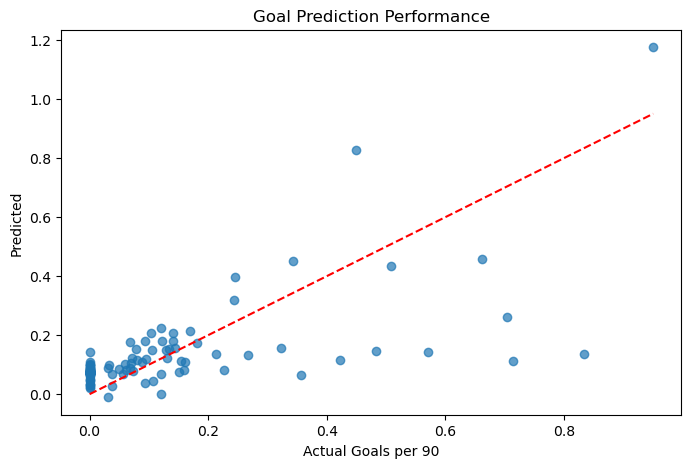

In [318]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Goals per 90")
plt.ylabel("Predicted")
plt.title("Goal Prediction Performance")
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.show()

In [319]:
print(y.isna().sum())

0


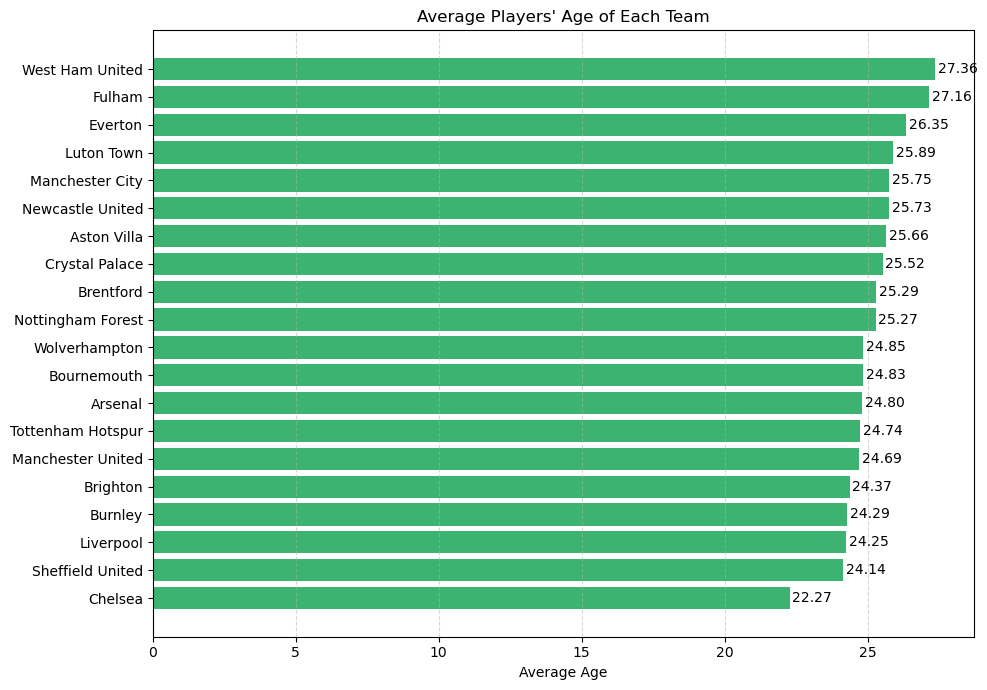

In [320]:
# คำนวณอายุเฉลี่ยของแต่ละทีม
avg_age = df.groupby('Team')['Age'].mean().sort_values(ascending=False)

# วาดกราฟแท่งแนวนอน
plt.figure(figsize=(10, 7))
bars = plt.barh(avg_age.index, avg_age.values, color='mediumseagreen')

# ใส่เลขอายุด้านหลังแท่ง
for bar, age in zip(bars, avg_age.values):
    plt.text(age + 0.1,            # ตำแหน่ง x (ชิดปลายแท่ง)
             bar.get_y() + bar.get_height() / 2,  # ตำแหน่ง y (ตรงกลางแท่ง)
             f'{age:.2f}',         # ตัวเลขแสดงเป็นทศนิยม 2 ตำแหน่ง
             va='center')

plt.xlabel('Average Age')
plt.title("Average Players' Age of Each Team")
plt.gca().invert_yaxis()  # แสดงทีมที่อายุสูงสุดไว้ด้านบน
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

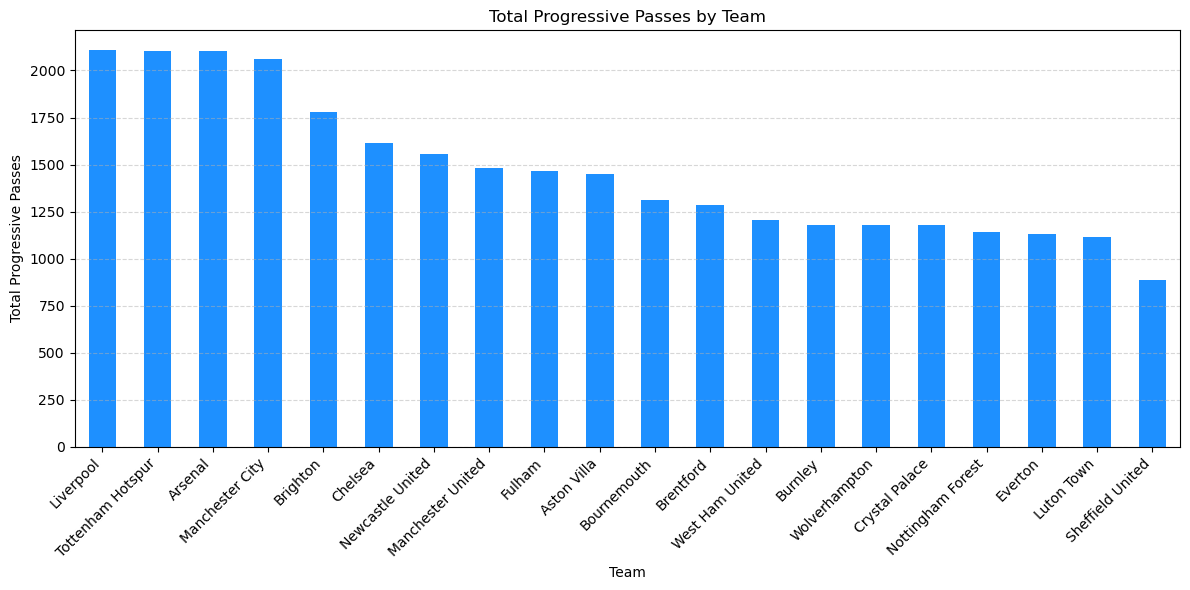

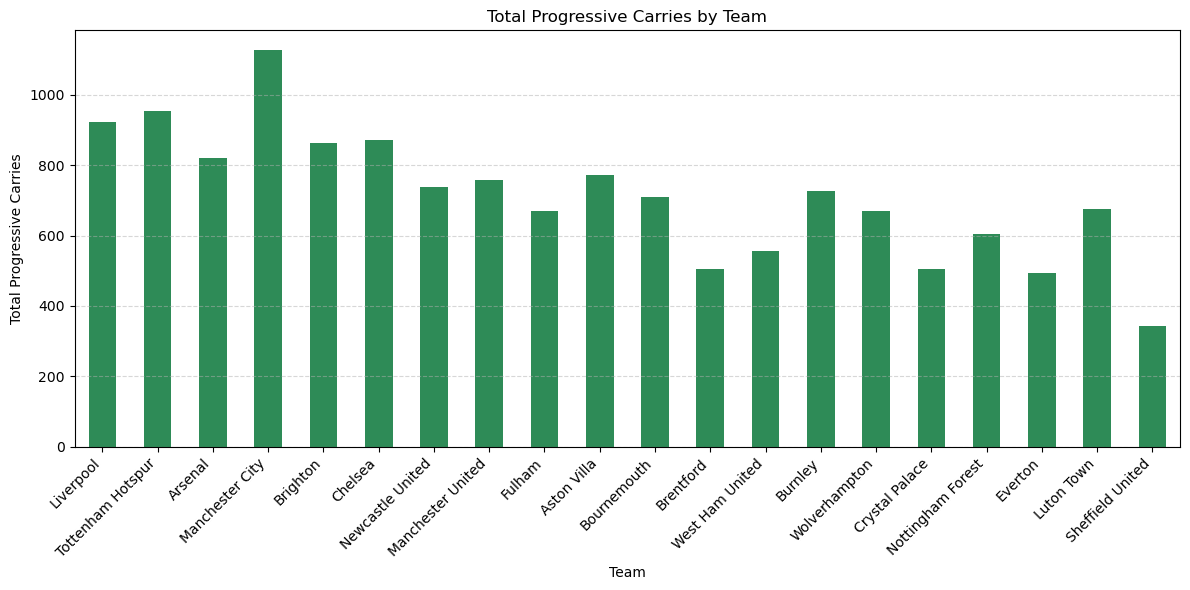

In [321]:
# รวมค่าสถิติการส่งบอลเชิงรุกต่อทีม
pass_stats = df.groupby('Team')[['PrgP', 'PrgC']].sum().sort_values(by='PrgP', ascending=False)

# วาดกราฟเปรียบเทียบ
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
pass_stats['PrgP'].plot(kind='bar', color='dodgerblue', label='Progressive Passes')
plt.ylabel('Total Progressive Passes')
plt.title('Total Progressive Passes by Team')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
pass_stats['PrgC'].plot(kind='bar', color='seagreen', label='Progressive Carries')
plt.ylabel('Total Progressive Carries')
plt.title('Total Progressive Carries by Team')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [322]:
# กรองเฉพาะผู้เล่นที่ได้ลงเล่นจริง
df = df[df['90s'] > 0]

# คำนวณค่าต่อ 90 นาที
df['GlsPer90'] = df['Gls'] / df['90s']
df['AstPer90'] = df['Ast'] / df['90s']

# คำนวณค่าเฉลี่ยในแต่ละตำแหน่ง
pos_avg = df.groupby('Pos')[['Starts', 'GlsPer90', 'AstPer90']].mean()
pos_avg.columns = [f'{col}_avg' for col in pos_avg.columns]
df = df.merge(pos_avg, left_on='Pos', right_index=True)

# เงื่อนไข: ฟอร์มดีแต่ได้ลงน้อย
df['UnderusedStar'] = (
    ((df['GlsPer90'] > df['GlsPer90_avg']) | (df['AstPer90'] > df['AstPer90_avg'])) &
    (df['Starts'] < df['Starts_avg'])
).astype(int)

# AgeScore: ดาวรุ่งได้คะแนน
df['AgeScore'] = (23 - df['Age']).clip(lower=0)

# คำนวณ transfer_score
df['transfer_score'] = (
    df['UnderusedStar'] * 1.5 +
    df['AgeScore'] * 0.3
)

# จัดกลุ่ม Transfer Opportunity
df['Transfer_Opportunity'] = df['transfer_score'].apply(
    lambda s: "MAY REQUEST MOVE" if s >= 1.5 else "STAY"
)

# แสดง Top 5 ผู้เล่นที่อาจขอย้าย
top_may_request_move = df[df['Transfer_Opportunity'] == 'MAY REQUEST MOVE'] \
    .sort_values('transfer_score', ascending=False) \
    [['Player', 'Pos', 'Age', 'Gls', 'Ast', 'Starts', 'transfer_score']].head(5)

print(" Top 5 Players Likely to Request a Move (Álvarez-type):")
print(top_may_request_move)

# แสดง Top 5 ผู้เล่นที่น่าจะอยู่ต่อ
top_stayers = df[df['Transfer_Opportunity'] == 'STAY'] \
    .sort_values('transfer_score', ascending=False) \
    [['Player', 'Pos', 'Age', 'Gls', 'Ast', 'Starts', 'transfer_score']].head(5)

print("\n Top 5 Players Likely to Stay:")
print(top_stayers)

 Top 5 Players Likely to Request a Move (Álvarez-type):
               Player    Pos   Age  Gls  Ast  Starts  transfer_score
124       Lewis Miley     MF  17.0  1.0  3.0      14             3.3
258     George Earthy     FW  18.0  1.0  0.0       0             3.0
16         Rico Lewis  DF,MF  18.0  2.0  0.0       8             3.0
131        Lewis Hall     DF  18.0  1.0  0.0       8             3.0
358  Jack Hinshelwood     DF  18.0  3.0  0.0       8             3.0

 Top 5 Players Likely to Stay:
                Player    Pos   Age  Gls  Ast  Starts  transfer_score
577  Antwoine Hackford     FW  19.0  0.0  0.0       0             1.2
562      William Osula     FW  19.0  0.0  0.0       9             1.2
558       Andre Brooks  MF,DF  19.0  0.0  0.0      12             1.2
352      Carlos Baleba     MF  19.0  0.0  0.0      15             1.2
364     Valentín Barco  DF,FW  19.0  0.0  0.0       3             1.2


In [323]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# เตรียมข้อมูล
df = df[df['90s'] > 0].dropna(subset=['Gls', 'xG', 'xAG', 'Ast', 'PrgP', 'PrgC', 'Age'])

# ฟีเจอร์ (X) และเป้าหมาย (y)
features = ['xG', 'xAG', 'Ast', 'PrgP', 'PrgC', 'Age']
X = df[features]
y = df['Gls']

# Scaling (สำคัญถ้าใช้โมเดลที่ sensitive กับขนาด เช่น Ridge, SVR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# สร้างโมเดล
model = LinearRegression()

# Cross-validation (K=5 fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')

# Train final model (optional)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Evaluation
print("Cross-Validation R2 Scores:", cv_scores)
print(" Average R2 Score:", np.mean(cv_scores))
print(" Final Model Performance on Full Data:")
print("   R2:", r2_score(y, y_pred))
print("   MSE:", mean_squared_error(y, y_pred))
print("   MAE:", mean_absolute_error(y, y_pred))

# เพิ่มคอลัมน์ผลทำนายลงใน DataFrame
df['Predicted_Gls'] = y_pred

# แสดง Top 10 ผู้เล่นที่โมเดลคาดว่าจะยิงเยอะสุด
top10_predicted = df.sort_values('Predicted_Gls', ascending=False) \
    [['Player', 'Pos', 'Age', 'Team', 'Gls', 'Predicted_Gls']].head(10)

print("\n🔝 Top 10 Players Predicted to Score the Most Goals Next Season:")
print(top10_predicted.to_string(index=False, float_format="%.2f"))

Cross-Validation R2 Scores: [0.8939038  0.80708354 0.85985799 0.90393503 0.86048313]
 Average R2 Score: 0.8650526983663898
 Final Model Performance on Full Data:
   R2: 0.8775953315545632
   MSE: 1.6403127213219502
   MAE: 0.7843364188811446

🔝 Top 10 Players Predicted to Score the Most Goals Next Season:
         Player   Pos   Age             Team   Gls  Predicted_Gls
 Erling Haaland    FW 23.00  Manchester City 27.00          27.89
  Mohamed Salah    FW 31.00        Liverpool 18.00          21.22
 Alexander Isak    FW 23.00 Newcastle United 21.00          19.50
Dominic Solanke    FW 25.00      Bournemouth 19.00          18.77
    Cole Palmer FW,MF 21.00          Chelsea 22.00          18.44
Nicolas Jackson    FW 22.00          Chelsea 14.00          18.03
  Ollie Watkins    FW 27.00      Aston Villa 19.00          16.72
   Darwin Núñez    FW 24.00        Liverpool 11.00          16.02
    Bukayo Saka    FW 21.00          Arsenal 16.00          15.90
 Julián Álvarez MF,FW 23.00  Manc

In [ ]:
# 1. เริ่ม Git (ถ้ายังไม่ init)
!git init && echo "✅ git init done"

# 2. เพิ่มไฟล์ .ipynb
!git add "EPL Analyst.ipynb" && echo "✅ added notebook"

# 3. Commit พร้อมข้อความ
!git commit -m "Add EPL Analyst notebook" && echo "✅ committed"

# 4. เชื่อมกับ GitHub repo (ถ้ามี origin อยู่แล้ว ให้ใช้ set-url)
!git remote set-url origin https://github.com/SALM0Ns/-Premier-League-2023-2024-Pridiction.git && echo "✅ remote set"

# 5. Push ขึ้น GitHub
!git push -u origin main